# Neurogenesis Demo
Train an autoencoder on a small MNIST subset and generate intrinsic replay samples.

In [1]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.loggers import MLFlowLogger

from data.mnist_datamodule import MNISTDataModule
from models.autoencoder import AutoEncoder
from training.intrinsic_replay_runner import run_intrinsic_replay

In [30]:
# datamodule restricted to digits 0 and 1
dm = MNISTDataModule(batch_size=64, num_workers=0, classes=[1, 7])
dm.setup()

In [33]:
# LightningModule wrapping the AutoEncoder
class LitWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.ae = model
        self.loss_fn = torch.nn.MSELoss()
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.ae(x)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        out = self(imgs)
        loss = self.loss_fn(out["recon"], imgs.view(imgs.size(0), -1))
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        out = self(imgs)
        self._last_imgs = imgs
        self._last_recons = out["recon"].view_as(imgs)
        loss = self.loss_fn(out["recon"], imgs.view(imgs.size(0), -1))
        self.val_losses.append(loss.item())
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def on_validation_epoch_end(self):
        grid = torchvision.utils.make_grid(
            torch.cat([self._last_imgs, self._last_recons], dim=0),
            nrow=self._last_imgs.size(0),
        )
        self.example_grid = grid
        self._last_imgs = None
        self._last_recons = None

In [35]:
model = AutoEncoder(input_dim=28 * 28, hidden_sizes=[200, 100, 60, 20], activation="relu")
lit = LitWrapper(model)
logger = MLFlowLogger(experiment_name="demo")
trainer = pl.Trainer(max_epochs=20, logger=logger)
trainer.fit(lit, dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | ae      | AutoEncoder | 369 K  | train
1 | loss_fn | MSELoss     | 0      | train
------------------------------------------------
369 K     Trainable params
0         Non-trainable params
369 K     Total params
1.478     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


c:\Users\Admin\Anaconda3\envs\neurogenesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Admin\Anaconda3\envs\neurogenesis\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 204/204 [00:06<00:00, 30.36it/s, v_num=2199]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 204/204 [00:06<00:00, 30.15it/s, v_num=2199]


Train losses: [0.2359105795621872, 0.23549261689186096, 0.23438480496406555, 0.2331373244524002, 0.23094692826271057, 0.22935783863067627, 0.22651393711566925, 0.22423280775547028, 0.22118018567562103, 0.21634899079799652, 0.2105301022529602, 0.20352639257907867, 0.195905402302742, 0.1825808435678482, 0.16793550550937653, 0.15020433068275452, 0.12799322605133057, 0.10457459092140198, 0.0857953354716301, 0.07361143082380295, 0.06193254142999649, 0.05386008322238922, 0.05156416818499565, 0.0639014020562172, 0.06609786301851273, 0.05754610896110535, 0.05370244011282921, 0.05081970617175102, 0.05951330065727234, 0.05794428288936615, 0.0524938739836216, 0.0533212274312973, 0.05659668520092964, 0.048700690269470215, 0.0550350658595562, 0.05882390961050987, 0.05295640602707863, 0.05513795092701912, 0.05547342821955681, 0.052098192274570465, 0.05463670566678047, 0.05303969979286194, 0.05119829624891281, 0.054545171558856964, 0.052439361810684204, 0.05036197230219841, 0.052006252110004425, 0.05

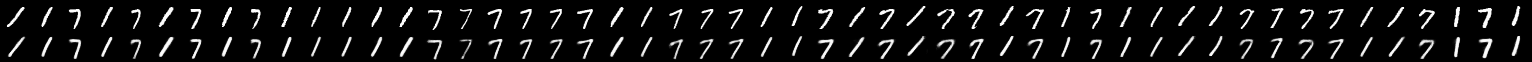

In [36]:
print("Train losses:", lit.train_losses)
print("Val losses:", lit.val_losses)
display(torchvision.transforms.ToPILImage()(lit.example_grid))

In [39]:
imgs_ir = run_intrinsic_replay(
    encoder=model.encoder,
    decoder=model.decoder,
    dataloader=dm.train_dataloader(),
    mlf_logger=logger,
    n_samples_per_class=4,
    device=trainer.strategy.root_device,
)

✅ intrinsic-replay artifacts logged under run 0994190b9dfd4b0493fb7ddbc4b72199


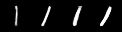

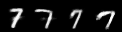

In [40]:
from torchvision.utils import make_grid

for b in imgs_ir:
    grid = make_grid(b, nrow=4, normalize=True)
    display(torchvision.transforms.ToPILImage()(grid))